In [1]:
# you do not need to change the content of this cell
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

In [2]:
# you do not need to change the content of this cell
from abc import ABC, abstractmethod
import json
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from typing import Any, List, Optional, Tuple, Union

In [3]:
# you do not need to change the content of this cell
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
# you do not need to change the content of this cell
spark = SparkSession.builder\
                    .master('local')\
                    .appName('DL')\
                    .getOrCreate()

Now that we have our autoencoder, we will prepare the logs. We will do it using spark via pyspark.

Please use queries (select, groupBy, filter, etc.) and functions (F.count, F.abs, etc.) to do the excercises. Do not use User-defined functions (UDF) (https://spark.apache.org/docs/latest/api/python/_modules/pyspark/sql/udf.html) which run python code on spark dataframes but are not efficient.

In [5]:
# you do not need to change the content of this cell
df = spark.read.json('./data/devices.json')

In [6]:
# you do not need to change the content of this cell
df.show()

+---------+---------+---------+----+-------------+
|client_id|device_id|   log_id|rssi|         time|
+---------+---------+---------+----+-------------+
|        1| 20339519|891826512|-106|1.584104401E9|
|        0| 12740761|891826577| -77|1.584104401E9|
|        2| 86533313|891826638| -63|1.584104401E9|
|        1| 25634086|891826661| -51|1.584104401E9|
|        0| 15891821|891826696| -62|1.584104401E9|
|        0| 13711168|891826711| -29|1.584104401E9|
|        0| 12272690|891826490|-102|1.584104402E9|
|        0| 13115769|891826504|-106|1.584104402E9|
|        1| 25103605|891826541| -86|1.584104402E9|
|        1| 29758359|891826545| -34|1.584104402E9|
|        3| 24731158|891826553| -90|1.584104402E9|
|        0| 28275422|891826571| -53|1.584104402E9|
|        2| 66935406|891826641| -84|1.584104402E9|
|        1| 77356693|891826658| -51|1.584104402E9|
|        1| 20762046|891826665| -75|1.584104402E9|
|        0| 28717060|891826672| -34|1.584104402E9|
|        0| 14304009|891826691|

In [7]:
# you do not need to change the content of this cell
df.count()

388215

As you can see, the logs have 5 columns:
    - the client_id
    - the device_id
    - the log_id (unique for each row)
    - the Received Signal Strength Indicator
    - a timestamp
    
The logs contain only the columns required to solve our problem: predicting missing connections.

Intuitively, we understand that the problem is a problem of distance between log entries (the `time` column) for each device.

We will thus perform data augmentation to compute the time elapsed, for each device, between the current entry and the preceeding one.

To do that, you must use the `Window`function of pyspark to add an `elapsed` column to the dataset. Here is a good resource to help you start with window functions: https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html.

You will know that your query is right if you get a majority of values around `3600.0` (machines connect every hour). Note that a few entries could be higher than 3600.0 and that the first entries will be `null`.

You must see something like:

In [17]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL
windowSpec = \
  Window.partitionBy(df['device_id']).orderBy(df['time'].desc())
# we get the time elapsed
df = df.withColumn('elapsed',-df['time']+F.lag('time',1).over(windowSpec)


                  )
df.show()

+---------+---------+---------+----+-------------+-------+
|client_id|device_id|   log_id|rssi|         time|elapsed|
+---------+---------+---------+----+-------------+-------+
|        0| 27149139|891926485| -32|1.585598402E9|   null|
|        0| 27149139|891926241| -30|  1.5855948E9| 3602.0|
|        0| 27149139|891925998| -35|  1.5855912E9| 3600.0|
|        0| 27149139|891925758| -36|  1.5855876E9| 3600.0|
|        0| 27149139|891925516| -35|   1.585584E9| 3600.0|
|        0| 27149139|891925270| -36|  1.5855804E9| 3600.0|
|        0| 27149139|891925031| -30|  1.5855768E9| 3600.0|
|        0| 27149139|891924789| -30|  1.5855732E9| 3600.0|
|        0| 27149139|891924542| -36|1.585569602E9| 3598.0|
|        0| 27149139|891924302| -35|   1.585566E9| 3602.0|
|        0| 27149139|891924060| -32|  1.5855624E9| 3600.0|
|        0| 27149139|891923813| -30|  1.5855588E9| 3600.0|
|        0| 27149139|891923571| -32|  1.5855552E9| 3600.0|
|        0| 27149139|891923333| -33|  1.5855516E9| 3600.

We will now try to define in which extent the missing connections are linked to a bad signal. 


To do that, write a spark query that sums the number of missing connections for each device and add the mean rssi of the device. Create four columns: 
- `zero_missing` (less than eg. 3800.0 seconds have elapsed since the last connection -  note that we wait for 3800 seconds to leave some room for machines having a temporary connection problem);
- `one_missing`(3800 to 7300 seconds have elapsed);
- `two_plus_missing` (more than 7300 seconds have elapsed);
- `avg_rssi` for the mean rssi.

You can do that using the spark built-in functions we imported in `import pyspark.sql.functions as F`.

Sort your columns by `two_plus_missing`, `one_missing`, `zero_missing`.

You will see something like:

In [29]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL

df_missing = df.groupBy('device_id').agg(
    F.count(F.when(df['elapsed']< 3800,True)).alias('zero_missing'),
    F.count(F.when((df['elapsed']> 3800) & (df['elapsed']< 7300), True)).alias('one_missing'),
    F.count(F.when(df['elapsed']> 7300, True)).alias('two_plus_missing'),
    F.avg(df['rssi'])




                )\
                .sort(
                    F.col('two_plus_missing').desc(),
                    F.col('one_missing').desc(),
                    F.col('zero_missing').desc()
                )

df_missing.show(100)

+---------+------------+-----------+----------------+-------------------+
|device_id|zero_missing|one_missing|two_plus_missing|          avg(rssi)|
+---------+------------+-----------+----------------+-------------------+
| 86533313|         934|          0|             105| -64.10288461538461|
| 11399616|         953|          0|             104| -76.01890359168242|
| 32943260|        1010|          0|             101| -85.98111510791367|
| 23744340|        1058|          0|             100|              -55.0|
| 24191837|         952|          0|             100|-100.90693257359924|
| 93330303|         963|          0|              99| -82.95954844778927|
| 27998249|        1014|          0|              95| -56.01531531531531|
| 66935406|         995|          0|              94|  -80.9770642201835|
| 21168733|        1141|          0|              92| -59.04294975688817|
| 29864881|        1035|          0|              91|-45.975155279503106|
| 23252650|        1080|          0|  

We will now put a 0 or 1 label on our data. This label will not be used to train our autoencoder but will help us do a summary distinction between devices facing a big service disruption and the "normal" ones.

Add a `label` column to the dataframe and fill it with `1` if 
- the device has more than two missing connections (df wide) AND
- the time elapsed between the current row entry and the preceeding one is more than 3700 seconds.

Otherwise, fill the label column with a `0`.

You can join dataframes by calling the `join` function on them.

You should see something like

In [35]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL

# labelize the data
# ouliers are devices displaying a big nb of missed log entries

# where > 3700 and 2+ missing
df_labelized = df\
                .join(df_missing, ['device_id'])\
                .withColumn('label', F.expr("CASE WHEN elapsed > 3700 THEN '1' WHEN two_plus_missing>0 THEN '1' ELSE '0' END"))
                                 
                            
                            

# show inliners
df_labelized.filter(F.col('label') == 0).show()

+---------+---------+---------+----+-------------+-------+------------+-----------+----------------+------------------+-----+
|device_id|client_id|   log_id|rssi|         time|elapsed|zero_missing|one_missing|two_plus_missing|         avg(rssi)|label|
+---------+---------+---------+----+-------------+-------+------------+-----------+----------------+------------------+-----+
| 27496805|        3|891926479| -70|  1.5855984E9|   null|        1987|          7|               0|-67.04812030075188|    0|
| 27496805|        3|891926235| -70|1.585594801E9| 3599.0|        1987|          7|               0|-67.04812030075188|    0|
| 27496805|        3|891925992| -66|  1.5855912E9| 3601.0|        1987|          7|               0|-67.04812030075188|    0|
| 27496805|        3|891925752| -65|  1.5855876E9| 3600.0|        1987|          7|               0|-67.04812030075188|    0|
| 27496805|        3|891925510| -68|   1.585584E9| 3600.0|        1987|          7|               0|-67.04812030075188

We will now group our logs by devices and into sequences of rssi, time and elapsed. 

For example, having:
    - log 1 of device 1
    - log 2 of device 1
    - log 3 of device 1
    - log 1 of device 2
    - log 2 of device 2
    - log 4 of device 1
    - log 1 of device 3
    - log 3 of device 2
    - log 2 of device 3

and sequences of length 3, we want the query to return 
    - 1, 2, 3 of device 1
    - 2, 3, 4 of device 1
    - 1, 2, 3 of device 2
    - nothing for device 3, who has only 2 entries

The order of the sequences in each log is important but the order of the logs not so much.

You will see something like:

This exercise is difficult and you will need a few queries to perform it. You will have to use `Window` functions. `F.collect_list` can also help you. You can access the items in spark lists using `F.col('name_of_col_containing_a_lis').getItem(i)`.

In [86]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL


PREVIOUS_ROWS = 5
windowSpec = \
  Window.partitionBy(df_labelized['device_id'])
df_sequence= df_labelized.groupBy('device_id','log_id','label','time','elapsed','rssi').agg(F.collect_list('time').over(windowSpec)[0].alias("time_0"), (F.collect_list('elapsed').over(windowSpec)[0]).alias("elapsed_0"), F.collect_list('rssi').over(windowSpec)[0].alias("rssi_0"))
df_sequence= df_sequence.join(df_labelized.groupBy('device_id','log_id','label','time','elapsed','rssi').agg(F.collect_list('time').over(windowSpec)[1].alias("time_1"), (F.collect_list('elapsed').over(windowSpec)[1]).alias("elapsed_1"), F.collect_list('rssi').over(windowSpec)[1].alias("rssi_1")), ['device_id','log_id','label','time','elapsed','rssi'])


for k in range(1,PREVIOUS_ROWS):
    df_sequence= df_sequence.join(df_labelized.groupBy('device_id','log_id','label','time','elapsed','rssi').agg(F.collect_list('time').over(windowSpec)[k].alias("time_{}".format(k)), (F.collect_list('elapsed').over(windowSpec)[k]).alias("elapsed_{}".format(k)), F.collect_list('rssi').over(windowSpec)[k].alias("rssi_{}".format(k))), ['device_id','log_id','label','time','elapsed','rssi'])



















        
df_sequence.show()

+---------+---------+-----+-------------+-------+----+-----------+---------+------+-------------+---------+------+-------------+---------+------+-------------+---------+------+-----------+---------+------+----------+---------+------+
|device_id|   log_id|label|         time|elapsed|rssi|     time_0|elapsed_0|rssi_0|       time_1|elapsed_1|rssi_1|       time_1|elapsed_1|rssi_1|       time_2|elapsed_2|rssi_2|     time_3|elapsed_3|rssi_3|    time_4|elapsed_4|rssi_4|
+---------+---------+-----+-------------+-------+----+-----------+---------+------+-------------+---------+------+-------------+---------+------+-------------+---------+------+-----------+---------+------+----------+---------+------+
| 10110554|891552090|    0|   1.578564E9| 3600.0| -81|1.5855984E9|   3598.0|   -80|1.585594802E9|   3600.0|   -77|1.585594802E9|   3600.0|   -77|1.585591202E9|   3602.0|   -77|1.5855876E9|   3600.0|   -81|1.585584E9|   3599.0|   -77|
| 10110554|891611743|    0|1.580079602E9| 3598.0| -83|1.5855984E

We will now collect the dataframe into a numpy array (it cannot be passed directly to our autoencoder).

In [87]:
# you do not need to change the content of this cell
array_sequences =  np.array(df_sequence.drop('device_id').drop('log_id').collect(), dtype=np.float64)

In [88]:
# you do not need to change the content of this cell
array_sequences[0]

array([ 0.0000000e+00,  1.5785640e+09,  3.6000000e+03, -8.1000000e+01,
        1.5855984e+09,  3.5980000e+03, -8.0000000e+01,  1.5855948e+09,
        3.6000000e+03, -7.7000000e+01,  1.5855948e+09,  3.6000000e+03,
       -7.7000000e+01,  1.5855912e+09,  3.6020000e+03, -7.7000000e+01,
        1.5855876e+09,  3.6000000e+03, -8.1000000e+01,  1.5855840e+09,
        3.5990000e+03, -7.7000000e+01])

In [89]:
# you do not need to change the content of this cell
array_sequences.shape

(387960, 22)

In [90]:
# you do not need to change the content of this cell
infs = np.where(np.isinf(array_sequences))
print(infs)
nans = np.where(np.isnan(array_sequences))
print(nans)

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


We separate our data into a train, validation and test set.

In [99]:
# you do not need to change the content of this cell
data_train, data_test = train_test_split(array_sequences, test_size=0.2, random_state=42)
data_train, data_valid = train_test_split(array_sequences, test_size=0.2, random_state=42)

In [100]:
# you do not need to change the content of this cell
data_train = np.array(data_train)
data_test = np.array(data_test)
data_valid = np.array(data_valid)

In [101]:
# you do not need to change the content of this cell
data_valid.dtype

dtype('float64')

In [102]:
# you do not need to change the content of this cell
def get(data, label_col_index=0):
    inliners = data[np.where(data[:,label_col_index] == 0)]
    outliers = data[np.where(data[:,label_col_index] > 0)]
    both = data
    # delete the label
    inliners = np.delete(inliners, label_col_index, 1)  
    outliers = np.delete(outliers, label_col_index, 1)
    both     = np.delete(both, label_col_index, 1)
    return inliners, outliers, both

data_train_inliner, data_train_outlier, data_train_clean = get(data_train)
print(data_train_inliner.shape, data_train_outlier.shape, data_train_clean.shape)

data_test_inliner, data_test_outlier, data_test_clean = get(data_test)
print(data_test_inliner.shape, data_test_outlier.shape, data_test_clean.shape)

data_valid_inliner, data_valid_outlier, data_valid_clean = get(data_valid)
print(data_valid_inliner.shape, data_valid_outlier.shape, data_valid_clean.shape)

(280831, 21) (29537, 21) (310368, 21)
(70211, 21) (7381, 21) (77592, 21)
(70211, 21) (7381, 21) (77592, 21)


We must now standardize our data. Use sklearn.preprocessing.StandardScaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [105]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL

scaler = StandardScaler().fit(data_train_inliner)

data_train_inliner_rescaled=scaler.transform(data_train_inliner)


scaler = StandardScaler().fit(data_train_outlier)

data_train_outlier_rescaled=scaler.transform(data_train_outlier)

scaler = StandardScaler().fit(data_train_clean)

data_train_clean_rescaled=scaler.transform(data_train_clean)

scaler = StandardScaler().fit(data_test_inliner)

data_test_inliner_rescaled=scaler.transform(data_test_inliner)


scaler = StandardScaler().fit(data_test_outlier)

data_test_outlier_rescaled=scaler.transform(data_test_outlier)

scaler = StandardScaler().fit(data_test_clean)

data_test_clean_rescaled=scaler.transform(data_test_clean)


scaler = StandardScaler().fit(data_valid_inliner)

data_valid_inliner_rescaled=scaler.transform(data_valid_inliner)


scaler = StandardScaler().fit(data_valid_outlier)

data_valid_outlier_rescaled=scaler.transform(data_valid_outlier)

scaler = StandardScaler().fit(data_valid_clean)

data_valid_clean_rescaled=scaler.transform(data_valid_clean)





We can now train our autoencoder. We will use Tensorflow and Keras.

Note that we cannot use the autoencoder we wrote yesterday because it lacks optimization and will be too slow.

In [106]:
# you do not need to change the content of this cell

from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import regularizers

In [107]:
# the values entered in this cell should work but feel free to modify them.

nb_epoch = 25
batch_size = 128
input_dim = data_train_inliner_rescaled.shape[1]
encoding_dim = 7
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 154       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 28        
_________________________________________________________________
dense_4 (Dense)              (None, 21)                168       
Total params: 386
Trainable params: 386
Non-trainable params: 0
_______________________________________________________________

In [108]:
# you do not need to change the content of this cell

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

history = autoencoder.fit(data_train_inliner_rescaled, data_train_inliner_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(data_valid_inliner_rescaled, data_valid_inliner_rescaled),
                    verbose=1).history

Epoch 1/25
2194/2194 [==============================] - 12s 5ms/step - loss: 0.3926 - accuracy: 0.2049 - val_loss: 0.2467 - val_accuracy: 0.2473
Epoch 2/25
2194/2194 [==============================] - 13s 6ms/step - loss: 0.2256 - accuracy: 0.2857 - val_loss: 0.2199 - val_accuracy: 0.2947
Epoch 3/25
2194/2194 [==============================] - 10s 4ms/step - loss: 0.2166 - accuracy: 0.2929 - val_loss: 0.2173 - val_accuracy: 0.2679
Epoch 4/25
2194/2194 [==============================] - 10s 5ms/step - loss: 0.2146 - accuracy: 0.2888 - val_loss: 0.2155 - val_accuracy: 0.2787
Epoch 5/25
2194/2194 [==============================] - 10s 5ms/step - loss: 0.2025 - accuracy: 0.3168 - val_loss: 0.1897 - val_accuracy: 0.3163
Epoch 6/25
2194/2194 [==============================] - 10s 5ms/step - loss: 0.1794 - accuracy: 0.3622 - val_loss: 0.1769 - val_accuracy: 0.3765
Epoch 7/25
2194/2194 [==============================] - 10s 5ms/step - loss: 0.1736 - accuracy: 0.3989 - val_loss: 0.1742 - val_ac

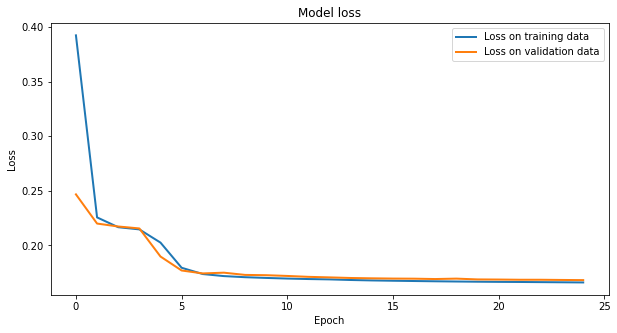

In [109]:
plt.plot(history['loss'], linewidth=2, label='Loss on training data')
plt.plot(history['val_loss'], linewidth=2, label='Loss on validation data')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

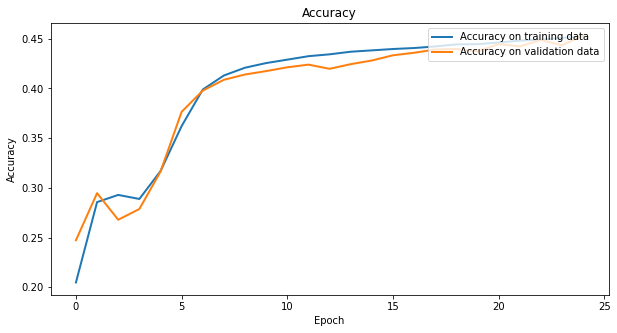

In [110]:
plt.plot(history['accuracy'], linewidth=2, label='Accuracy on training data')
plt.plot(history['val_accuracy'], linewidth=2, label='Accuracy on validation data')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

We will now test it on rou test data.

In [111]:
# you do not need to change the content of this cell
predictions = autoencoder.predict(data_test_clean_rescaled)

In [112]:
# you do not need to change the content of this cell
mse = np.mean(np.power(data_test_clean_rescaled - predictions, 2), axis=1)

In [113]:
# you do not need to change the content of this cell
def plot_mse(inliners_mse:np.ndarray, outliers_mse:np.ndarray, threshold:float, color:str, class_:str):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
 
    ax1.scatter(np.arange(inliners_mse.shape[0]), inliners_mse, color='blue', alpha=0.1)
    ax2.scatter(np.arange(outliers_mse.shape[0]), outliers_mse, color='grey', alpha=0.1)
    
    ax1.hlines(threshold, ax1.get_xlim()[0], ax1.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax2.hlines(threshold, ax2.get_xlim()[0], ax2.get_xlim()[1], colors="r", zorder=100, label='Threshold')

    plt.show()
    

In [114]:
# you do not need to change the content of this cell
inliners_mse = mse[np.where(data_test[:,0] == 0)]  # get inliners (label == 0)
print(inliners_mse.shape)
outliers_mse = mse[np.where(data_test[:,0] == 1)]   # get inliners (label == 1)
print(outliers_mse.shape)
print(data_train[:,0])

(70211,)
(7381,)
[0. 0. 0. ... 0. 0. 0.]


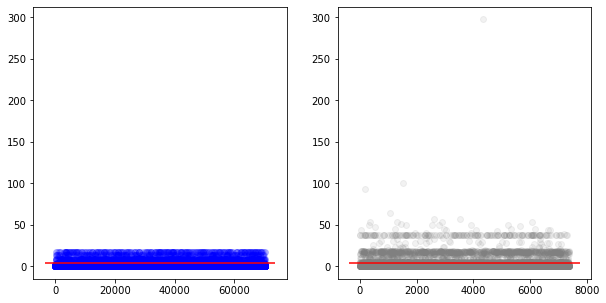

In [115]:
# you do not need to change the content of this cell
plot_mse(inliners_mse, outliers_mse, 4.0, 'blue', 'inliner')

In [116]:
# you do not need to change the content of this cell
def plot_confusion_matrix(mse: np.ndarray, labels: np.ndarray, threshold:int):
    pred_y = [1 if e > threshold else 0 for e in mse]
    cm = confusion_matrix(labels, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, xticklabels=["Normal","Break"], yticklabels=["Normal","Break"], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

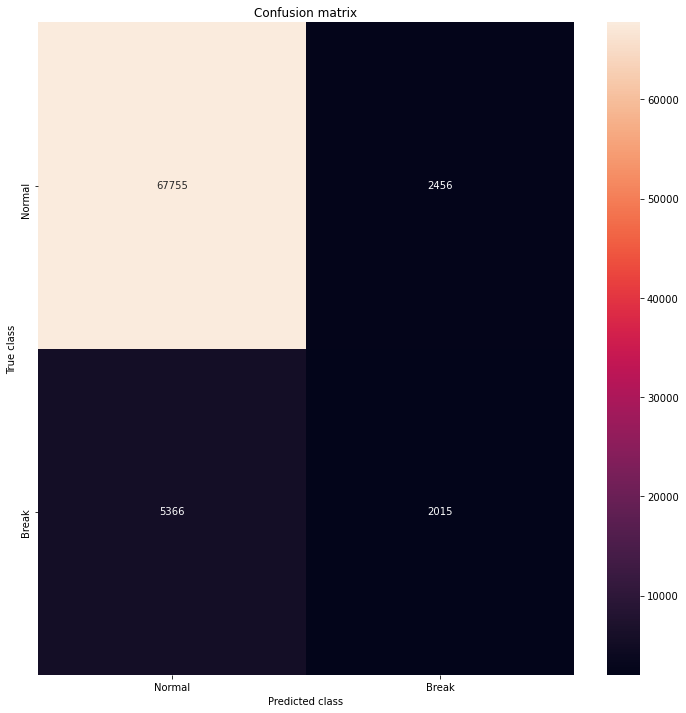

In [117]:
# you do not need to change the content of this cell
plot_confusion_matrix(mse, data_test[:,0], 4.0)